In [65]:
import urllib
import matplotlib.pyplot as plt
import pandas as pd
import unidecode
import json
import re
import numpy as np
import unidecode
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, GRU, LSTM
from keras.layers.embeddings import Embedding
from keras.initializers import Constant 
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

# BUILDING A PERSONAL ATTACK CLASSIFIER USING LSTM 

This notebook gives an end to end overview on how to build a LSTM NN classifier for detecting
personal attacks.

It is a personal take on the Wikipedia detox project's work on building machine learning models for detecting personal attacks and aggressive tone in user and article talk page comments.

Wikipedia detox project achievement is outlined in [Ex Machina: Personal Attacks Seen at Scale](https://arxiv.org/abs/1610.08914)

*Reference : Wulczyn, Ellery; Thain, Nithum; Dixon, Lucas (2016): [Wikipedia Detox](https://meta.wikimedia.org/wiki/Research:Detox/Data_Release)*








### Table of Contents

* [I. Data pre-processing](#1)
    * [1. download the dataset](#11)
    * [2. data cleaning](#12)
    * [3. data vectorization](#13)
* [II. Building the classifier](#2)
    * [1. word embedding](#21)
    * [2. building the NN](#22)
    * [3. training](#23)
* [III. Prediction & Model evaluation](#3)
    * [1. evaluation](#31)
    * [2. prediction](#32)

## I. Data preprocessing<a class="anchor" id="1"></a>

We will be using various data sets from [Wikipedia Talk](https://figshare.com/projects/Wikipedia_Talk/16731) project on Figshare. The release includes:

1. a large historical corpus of discussion comments on Wikipedia talk pages
2. a sample of over 100k comments with human labels for whether the comment contains a personal attack
3. a sample of over 100k comments with human labels for whether the comment has aggressive tone

Each comment was labeled by multiple annotators via Crowdflower on whether it is a toxic or healthy contribution.
A comment is considered toxic if a majority of annotators labelized the comment as an attack.

### I.1. download the dataset <a class="anchor" id="11"></a>
*NOTICE : running the cell above is only required on first usage*

In [4]:
# download annotated comments and annotations

ANNOTATED_COMMENTS_URL = 'https://ndownloader.figshare.com/files/7554634' 
ANNOTATIONS_URL = 'https://ndownloader.figshare.com/files/7554637' 

def download_file(url, fname):
    urllib.request.urlretrieve(url, fname)
    
download_file(ANNOTATED_COMMENTS_URL, 'attack_annotated_comments.tsv')
download_file(ANNOTATIONS_URL, 'attack_annotations.tsv')

In [8]:
comments = pd.read_csv('attack_annotated_comments.tsv', sep = '\t', index_col = 0)
annotations = pd.read_csv('attack_annotations.tsv',  sep = '\t')

In [9]:
# labels a comment as an atack if the majority of annotatators did so
labels = annotations.groupby('rev_id')['attack'].mean() > 0.5
# join labels and comments
comments['attack'] = labels

In [10]:
comments.head()

,comment,year,logged_in,ns,sample,split,attack
rev_id,,,,,,,
37675,`-NEWLINE_TOKENThis is not ``creative``. Thos...,2002,False,article,random,train,False
44816,`NEWLINE_TOKENNEWLINE_TOKEN:: the term ``stand...,2002,False,article,random,train,False
49851,"NEWLINE_TOKENNEWLINE_TOKENTrue or false, the s...",2002,False,article,random,train,False
89320,"Next, maybe you could work on being less cond...",2002,True,article,random,dev,False
93890,This page will need disambiguation.,2002,True,article,random,train,False


### I.2. text cleaning <a class="anchor" id="12"></a>

a.remove newline and tab tokens

In [91]:
comments['comment'] = comments['comment'].apply(lambda x: x.replace("NEWLINE_TOKEN", " "))
comments['comment'] = comments['comment'].apply(lambda x: x.replace("TAB_TOKEN", " "))

b. lower and remove non unicode characters

In [92]:
def standardize(text):
    return unidecode.unidecode(text.lower())

comments['comment'] = comments.comment.apply(standardize)

c. replacing contractions 
(i.e. he's => he is)

In [15]:
from flashtext import KeywordProcessor

with open('contractions.txt') as json_file:
    contraction_mapper = json.load(json_file)

contraction_processor = KeywordProcessor()
for k, v in contraction_mapper.items():
    contraction_processor.add_keyword(k, v)
    
replace_contraction = lambda x : contraction_processor.replace_keywords(x)

comments['comment'] = comments.comment.apply(replace_contraction)

d. remove non-alphabetical characters

In [90]:
def remove_non_alpha(text):
    regex = re.compile('[^a-zA-Z\s]')
    return regex.sub('', text)

comments['comment'] = comments.comment.apply(remove_non_alpha)

### I.3. data vectorization <a class="anchor" id="13"></a>
Transform corpus into sequences of tensors

a. tokenize comments

In [94]:
def tokenize(text):
    tokens = text.split(' ')
    tokens = [t for t in tokens if t != '']
    return tokens

comments['tokens'] = comments.comment.apply(tokenize) 

b.vectorize

In [21]:
max_length = 55

tokenizer = Tokenizer()

tokenized_comments = comments.tokens.tolist()

# Creating a vocabulary index based on word frequency.
tokenizer.fit_on_texts(tokenized_comments)
word_index = tokenizer.word_index

# Transforms each text in texts to a sequence of integers based on vocabulary index
sequences = tokenizer.texts_to_sequences(tokenized_comments)

# Ensures all sequences have the same length
lines_pad = pad_sequences(sequences, maxlen=max_length, padding='post')

c. train test split

In [27]:
Y = comments.attack.values.astype(int)

indices = np.arange(lines_pad.shape[0])

#Shuffling records in order to prevent potential bias due to the data collection process
np.random.shuffle(indices)

X = lines_pad[indices]
Y = Y[indices]

# split dataset in training and testing sets
validation_split = 0.3

num_validation_samples = int(validation_split * lines_pad.shape[0])

X_train = X[:-num_validation_samples]
y_train = Y[:-num_validation_samples]
X_test = X[-num_validation_samples:]
y_test = Y[-num_validation_samples:]

## II. Building the classifier <a class="anchor" id="2"></a>

### II.1. Word embedding <a class="anchor" id="21"></a>

a. Loading pre-trained glove model

In [30]:
import os

embedding_index = {}
embedding_dim = 100
glove_dir = "C:\glove.twitter.27B"
f = open(os.path.join(glove_dir, 'glove.twitter.27B.100d.txt'), encoding = "utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coeff = np.asarray(values[1:], dtype='float32')
    embedding_index[word] = coeff
f.close()

b. Building the embedding layer

In [31]:
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [32]:
embedding_layer = Embedding(len(word_index) + 1,
                            embedding_dim,
                            weights=[embedding_matrix],
                            input_length=max_length,
                            trainable=False)

### II.2. Building the model <a class="anchor" id="22"></a>

In [33]:
model = Sequential()

model.add(embedding_layer)

model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.25))

model.add(Dense(1, activation='sigmoid'))

model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['acc']
)

print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 55, 100)           18009500  
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 18,051,805
Trainable params: 42,305
Non-trainable params: 18,009,500
_________________________________________________________________
None


### II.3. Training <a class="anchor" id="23"></a>

In [34]:
checkpoint = ModelCheckpoint('model.h5', monitor='val_loss', save_best_only=True)

history = model.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=5,
    validation_data=(X_test, y_test),
    callbacks=[checkpoint],
    verbose=1
)

Instructions for updating:
Use tf.cast instead.
Train on 81105 samples, validate on 34759 samples
Epoch 1/5
81105/81105 [==============================] - 234s 3ms/step - loss: 0.2283 - acc: 0.9191 - val_loss: 0.1735 - val_acc: 0.9425
Epoch 2/5
81105/81105 [==============================] - 214s 3ms/step - loss: 0.1697 - acc: 0.9401 - val_loss: 0.1551 - val_acc: 0.9452
Epoch 3/5
81105/81105 [==============================] - 201s 2ms/step - loss: 0.1530 - acc: 0.9441 - val_loss: 0.1461 - val_acc: 0.9474
Epoch 4/5
81105/81105 [==============================] - 198s 2ms/step - loss: 0.1469 - acc: 0.9466 - val_loss: 0.1478 - val_acc: 0.9469
Epoch 5/5
81105/81105 [==============================] - 197s 2ms/step - loss: 0.1413 - acc: 0.9476 - val_loss: 0.1405 - val_acc: 0.9490


## III. Prediction & Model Evaluation <a class="anchor" id="3"></a>

### III.1. Evaluation <a class="anchor" id="31"></a>

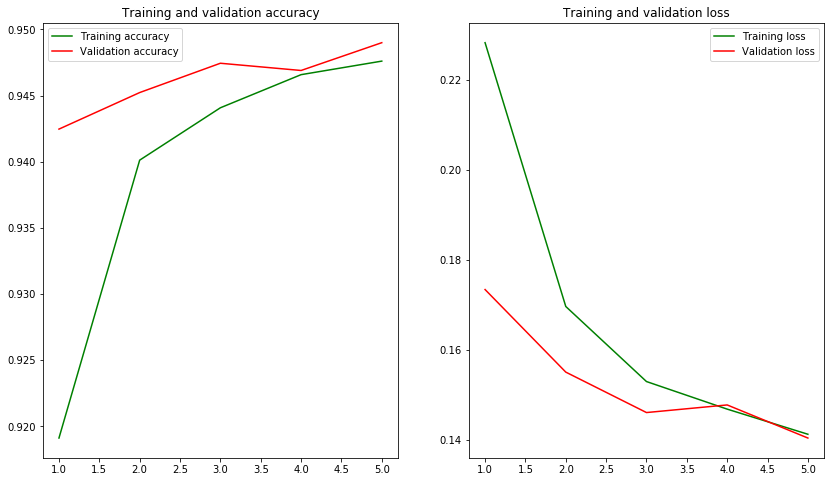

In [84]:
# Plot results
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

fig = plt.figure(figsize=(14,8))
ax1 = plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

ax2 = plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### III.2. Prediction <a class="anchor" id="32"></a>

In [60]:
def clean_text(text):
    text = standardize(text)
    text = replace_contraction(text)
    text = remove_non_alpha(text)
    return text

def process_text(text):
    tokens = [tokenize(text)]
    sequence = tokenizer.texts_to_sequences(tokens)
    padded_sequence = pad_sequences(sequence, maxlen=max_length, padding='post')
    return padded_sequence

def predict(text):
    cleaned_text =  clean_text(text) 
    padded_sequence = process_text(cleaned_text)
    prediction = model.predict(padded_sequence)
    return prediction[0][0]

In [78]:
message = "this is by far the dumbest thing i've heard! why can't you shut up for once! you are being a fool"
predict(message)

0.7707073

In [80]:
message2 = "how nice of you to have make this statement :)"
predict(message2)

0.0049714334

In [95]:
message3 = "You're such a FAG"
predict(message3)

0.93996817